The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

    train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
    test.tsv contains just phrases. You must assign a sentiment label to each phrase.

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [15]:
import pandas as pd
import re
from torchtext.data.utils import get_tokenizer
import numpy as np
import torch
import matplotlib.pyplot as plt
# 1. 加载数据
train_data = pd.read_csv('train.tsv', sep='\t')
# 2. 定义预处理函数
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(text.split())
    return text

# 3. 对数据进行预处理
train_data['Processed_Phrase'] = train_data['Phrase'].apply(preprocess_text)
# 4. Tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
# Tokenize the entire training set
tokenized_train = [tokenizer(item) for item in train_data['Processed_Phrase']]
# 1. Create a unique set of words from the tokenized sentences
unique_tokens = set(token for sentence in tokenized_train for token in sentence)
unique_tokens.update(['<pad>', '<unk>'])
# 2. Assign a unique index to each word
word_to_idx = {word: idx for idx, word in enumerate(unique_tokens)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
# 3. Convert tokenized sentences to indices using the manually built vocab
train_text_data = []
for tokens in tokenized_train:
    indexed_tokens = [word_to_idx.get(token, word_to_idx['<unk>']) for token in tokens]
    train_text_data.append(torch.tensor(indexed_tokens, dtype=torch.long))
train_label_data = train_data['Sentiment'].values.tolist()

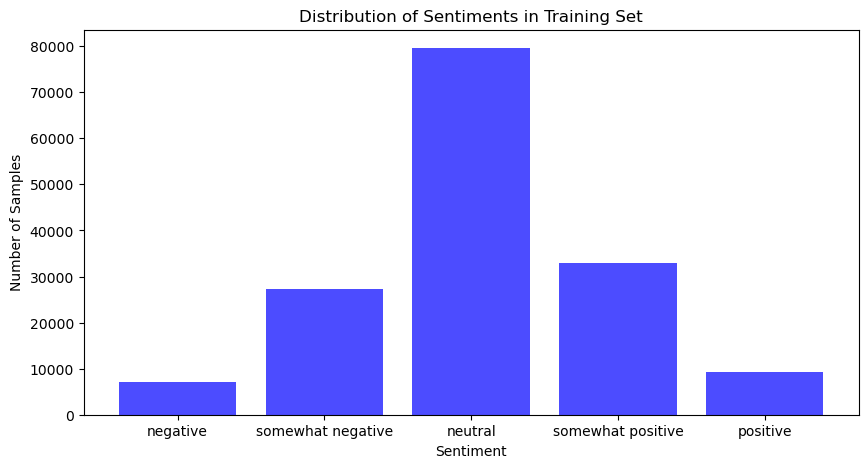

In [16]:
import pandas as pd
import re
from torchtext.data.utils import get_tokenizer
import numpy as np
import torch
from matplotlib import pyplot as plt

# 1. Load and preprocess data

# Load data
train_data = pd.read_csv('train.tsv', sep='\t')
test_data = pd.read_csv('test.tsv', sep='\t')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(text.split())
    return text

# Apply preprocessing
train_data['Processed_Phrase'] = train_data['Phrase'].apply(preprocess_text)

# Tokenization
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokenized_train = [tokenizer(item) for item in train_data['Processed_Phrase']]

# Create vocabulary
unique_tokens = set(token for sentence in tokenized_train for token in sentence)
unique_tokens.update(['<pad>', '<unk>'])
word_to_idx = {word: idx for idx, word in enumerate(unique_tokens)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert tokenized sentences to indices
train_text_data = []
for tokens in tokenized_train:
    indexed_tokens = [word_to_idx.get(token, word_to_idx['<unk>']) for token in tokens]
    train_text_data.append(torch.tensor(indexed_tokens, dtype=torch.long))
train_lable_data=train_data['Sentiment'].values.tolist()
plt.figure(figsize=(10, 5))
plt.hist(train_label_data, bins=[0,1,2,3,4,5], align='left', rwidth=0.8, color='blue', alpha=0.7)
plt.xticks(ticks=[0,1,2,3,4], labels=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sentiments in Training Set')
plt.show()
# Test data preprocessing
test_data['Processed_Phrase'] = test_data['Phrase'].apply(preprocess_text)
tokenized_test = [tokenizer(item) for item in test_data['Processed_Phrase']]
test_text_data = []
for tokens in tokenized_test:
    indexed_tokens = [word_to_idx.get(token, word_to_idx['<unk>']) for token in tokens]
    test_text_data.append(torch.tensor(indexed_tokens, dtype=torch.long))

# 2. Load GloVe vectors and create an embedding matrix

def load_glove(path):
    with open(path, 'r', encoding='utf-8') as f:
        word_to_vec = {}
        for line in f:
            line = line.strip().split()
            word = line[0]
            word_to_vec[word] = np.array(line[1:], dtype=np.float32)
    return word_to_vec

glove_path = 'glove.6B.300d.txt'
glove_vectors = load_glove(glove_path)

# Create embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
for word, idx in word_to_idx.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
    else:
        embedding_matrix[idx] = np.random.uniform(-0.25, 0.25, embedding_dim)



1. **导入库**:
    - 导入数据处理、文本处理、张量操作和数据可视化所需的库。

2. **数据加载与预处理**:
    - 从TSV文件中加载训练和测试数据。
    - 对文本数据进行预处理，包括转为小写、删除非字母字符和多余的空格。
    - 使用Spacy分词器对文本进行分词。
    - 创建词汇表并为每个词分配一个唯一索引。
    - 将分词后的文本转换为其对应的索引表示。
    - 可视化训练数据的情感分布。

3. **加载词向量**:
    - 从GloVe文件加载预训练的词向量。
    - 创建一个嵌入矩阵，其中包括每个词的嵌入向量。对于不在GloVe中的词，赋予其随机初始化的向量。

目的是为NLP任务准备文本数据，包括其预处理、分词、索引表示和加载预训练的词向量。

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels=1, 
                                              out_channels=n_filters, 
                                              kernel_size=(fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, sent len]
        
        embedded = self.embedding(text)
        
        # embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        # embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        
        # conv_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        
        # cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


使用卷积神经网络（CNN）进行文本分类的模型:
1. **初始化方法 (`__init__`)**:
    - 输入参数：
        - `vocab_size`: 词汇表大小。
        - `embedding_dim`: 嵌入向量的维度。
        - `n_filters`: 每种大小的滤波器的数量。
        - `filter_sizes`: 一个整数列表，表示每种滤波器的大小。
        - `output_dim`: 输出维度，定义为类别的数量。
        - `dropout`: dropout率，用于正则化。
        - `pad_idx`: padding的索引，用于嵌入层中。
    - 主要组件：
        - `embedding`: 将词索引转换为嵌入向量。
        - `convs`: 一系列的卷积层，每个滤波器大小对应一个卷积层。
        - `fc`: 全连接层，用于输出预测。
        - `dropout`: dropout层，用于正则化。

2. **前向传播方法 (`forward`)**:
    - 输入参数：
        - `text`: 输入文本的索引表示，形状为 [batch size, sentence length]。
    - 主要步骤：
        - 使用`embedding`层将文本索引转换为嵌入向量。
        - 增加一个维度，以适应卷积层的输入要求。
        - 对每个卷积层应用ReLU激活函数。
        - 使用最大池化层对每个卷积的输出进行池化。
        - 使用dropout层对所有池化的输出进行连接。
        - 使用全连接层输出预测。

模型的基本思想是使用多个不同大小的滤波器对输入文本进行卷积操作，捕获文本中不同长度的局部特征（即n-gram特征）。然后，这些特征通过最大池化层进行汇总，最后通过全连接层输出预测。

In [18]:
from torch.utils.data import DataLoader, Dataset
class PaddedTextDataset(Dataset):
    def __init__(self, text_data, label_data, pad_idx):
        self.text_data = text_data
        self.label_data = label_data
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        return self.text_data[idx], self.label_data[idx]

    def collate_fn(self, batch):
        texts, labels = zip(*batch)
        max_len = max([len(text) for text in texts])
        padded_texts = [torch.cat([text, torch.tensor([self.pad_idx] * (max_len - len(text)), dtype=torch.long)]) for text in texts]
        return torch.stack(padded_texts), torch.tensor(labels, dtype=torch.long)

pad_idx = word_to_idx['<pad>']
train_dataset = PaddedTextDataset(train_text_data, train_label_data, pad_idx)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)


创建了用于加载经过填充的文本数据的数据集类`PaddedTextDataset`，以及相应的数据加载器`train_loader`。

1. **PaddedTextDataset类**:
    - 这是一个继承自`torch.utils.data.Dataset`的自定义数据集类。
    
    - **初始化方法 (`__init__`)**:
        - 输入参数：
            - `text_data`: 已索引化的文本数据列表。
            - `label_data`: 相应的标签数据列表。
            - `pad_idx`: padding的索引，用于后续的填充操作。
        - 方法内部存储了输入参数为类属性。
    
    - **`__len__`方法**:
        - 返回数据集的总长度，即标签数据的长度。
    
    - **`__getitem__`方法**:
        - 输入参数`idx`，返回对应索引的文本和标签数据。
    
    - **`collate_fn`方法**:
        - 这是一个特殊的方法，用于在数据加载时对数据进行批量处理。它负责将文本数据填充到相同的长度。
        - 输入参数`batch`是一个文本和标签的元组列表。
        - 方法首先计算批次中最长的文本长度`max_len`。
        - 使用`pad_idx`对每个文本进行填充，使其长度与`max_len`相等。
        - 返回填充后的文本批次和标签批次。

2. **创建数据集和数据加载器**:
    - 使用`word_to_idx`字典中的`<pad>`标记得到`pad_idx`。
    - 使用`train_text_data`和`train_label_data`创建`PaddedTextDataset`实例。
    - 使用`DataLoader`创建`train_loader`，设置批大小为64，允许随机洗牌，并使用`collate_fn`方法进行批处理。

主要目的是为模型训练准备经过填充的数据。由于文本长度可能会有所不同，因此在送入模型之前，需要将它们填充到相同的长度。这可以通过`collate_fn`方法实现，该方法在数据加载时自动调用。

Training completed.


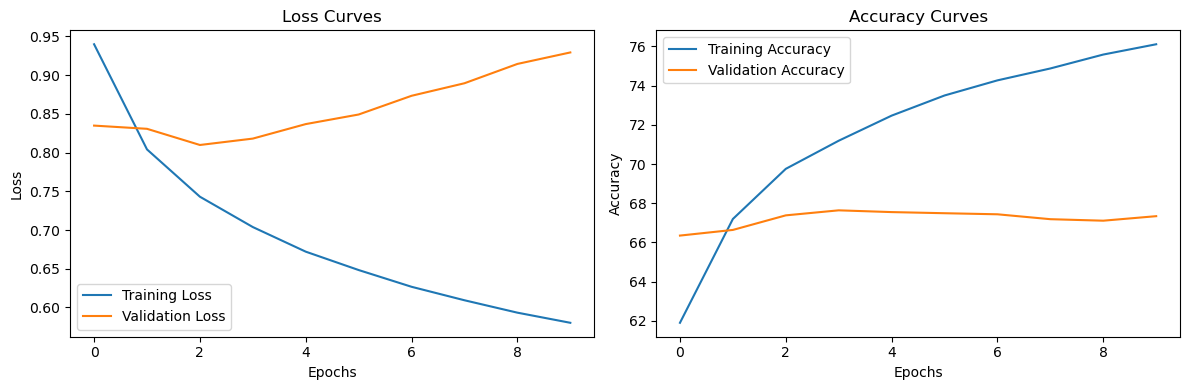

In [20]:
from sklearn.model_selection import train_test_split
# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_text_data, train_label_data, test_size=0.2)
# Create DataLoaders
train_dataset = PaddedTextDataset(train_texts, train_labels, pad_idx)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)

val_dataset = PaddedTextDataset(val_texts, val_labels, pad_idx)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=val_dataset.collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 300
output_dim = 5
n_filters = 100
filter_sizes = [3,4,5]
dropout = 0.5
pad_idx = word_to_idx['<pad>']

# Create model instance
model = TextCNN(len(word_to_idx), embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx).to(device)
# Copy pretrained embeddings
model.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
model.embedding.weight.requires_grad = True  # Freeze the embedding layer if you don't want to fine-tune it

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for text, labels in train_loader:
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = predictions.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for text, labels in val_loader:
            text, labels = text.to(device), labels.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            
            val_loss += loss.item()
            _, predicted = predictions.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

print("Training completed.")

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

模型训练和评估

1. **数据划分**:
    - 使用`train_test_split`从`sklearn`将原始训练数据划分为训练集和验证集。

2. **创建数据加载器**:
    - 使用先前定义的`PaddedTextDataset`类为训练和验证数据创建数据集。
    - 分别为训练和验证数据集创建`DataLoader`实例。

3. **模型和参数设置**:
    - 设置设备为GPU（如果可用）。
    - 定义模型的参数，如嵌入维度、输出维度、滤波器数量、滤波器大小等。
    - 使用`TextCNN`类创建模型实例并将其移动到指定的设备。
    - 将预训练的嵌入权重复制到模型的嵌入层。
    - 定义优化器（Adam）和损失函数（交叉熵损失）。

4. **模型训练**:
    - 对每个epoch：
        - 将模型设置为训练模式。
        - 在训练数据上迭代，并执行前向传播、损失计算、反向传播和优化。
        - 计算训练损失和准确性。
        - 设置模型为评估模式，并在验证数据上评估模型，计算验证损失和准确性。

5. **结果可视化**:
    - 使用`matplotlib`绘制训练和验证损失曲线。
    - 绘制训练和验证准确性曲线。

首先将数据划分为训练集和验证集，然后初始化模型、优化器和损失函数。接下来，进行多次迭代训练，每次迭代都在训练数据上训练模型，并在验证数据上评估模型。最后，绘制了损失和准确性曲线，以可视化模型的性能。

In [2]:
import random
from torch.utils.data import DataLoader

# Define the hyperparameter search space
search_space = {
    'lr': [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    'batch_size': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5, 0.6],
    'n_filters': [50, 100, 150, 200]
}

# Number of random combinations to try
n_combinations = 10

# Store the results of each combination
results = []

for _ in range(n_combinations):
    # Randomly sample from the search space
    lr = random.choice(search_space['lr'])
    batch_size = random.choice(search_space['batch_size'])
    dropout = random.choice(search_space['dropout'])
    n_filters = random.choice(search_space['n_filters'])
    
    # Create DataLoaders with selected batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)
    
    # Create model instance with selected parameters
    model = TextCNN(len(word_to_idx), embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx).to(device)
    model.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
    
    # Define optimizer with selected learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Placeholder for best validation loss and accuracy for this combination
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    
    # Train for a certain number of epochs (can be adjusted)
    for epoch in range(5):  # Reduced the number of epochs for demonstration
        model.train()
        for text, labels in train_loader:
            text, labels = text.to(device), labels.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(device), labels.to(device)
                predictions = model(text)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                _, predicted = predictions.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        
        # Update best validation loss and accuracy
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy

    # Store the results
    results.append({
        'lr': lr,
        'batch_size': batch_size,
        'dropout': dropout,
        'n_filters': n_filters,
        'best_val_loss': best_val_loss,
        'best_val_accuracy': best_val_accuracy
    })

# Sort the results by best validation accuracy
sorted_results = sorted(results, key=lambda x: x['best_val_accuracy'], reverse=True)

# Print the best combination
print(sorted_results[0])

随机搜索超参数优化，以在给定的搜索空间内找到最佳的超参数组合。

1. **定义超参数搜索空间**:
    - 定义了学习率、批大小、dropout率和滤波器数量的范围。

2. **随机搜索**:
    - 为随机搜索设置了尝试的组合数量（`n_combinations`）。
    - 对于每个随机组合：
        - 从搜索空间中随机选择超参数值。
        - 使用选定的批大小创建数据加载器。
        - 使用选定的参数创建模型实例。
        - 使用选定的学习率定义优化器。
        - 训练模型几个时代并评估其在验证集上的性能。
        - 记录该组合的最佳验证损失和准确性。

3. **结果排序和打印**:
    - 根据验证准确性对结果进行排序。
    - 打印最佳的超参数组合及其性能。



In [46]:
def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  # No need to track gradients
        for text, labels in data_loader:
            text, labels = text.to(device), labels.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            
            _, predicted = predictions.max(1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    average_loss = total_loss / len(data_loader)
    
    return average_loss, accuracy

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_text_data, train_label_data, test_size=0.1, random_state=42)

# Create datasets
train_dataset = PaddedTextDataset(train_texts, train_labels, word_to_idx['<pad>'])
valid_dataset = PaddedTextDataset(valid_texts, valid_labels, word_to_idx['<pad>'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, collate_fn=valid_dataset.collate_fn)

valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")


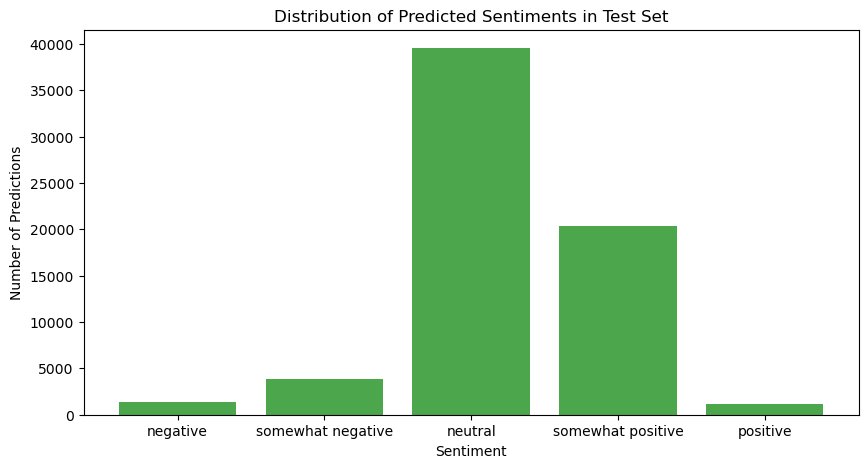

In [21]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 创建一个TensorDataset，因为测试集没有标签
test_dataset = TensorDataset(torch.nn.utils.rnn.pad_sequence(test_text_data, batch_first=True))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # 测试数据不需要打乱
def get_predictions(model, data_loader, device):
    model.eval()  # 设置模型为评估模式
    all_predictions = []

    with torch.no_grad():
        for texts in data_loader:
            texts = texts[0].to(device)  # 由于只有文本数据，所以选择第一个元素
            predictions = model(texts)
            _, predicted = torch.max(predictions, 1)  # 获取最大概率的索引
            all_predictions.extend(predicted.cpu().numpy())

    return all_predictions

test_predictions = get_predictions(model, test_loader, device)
#print(test_predictions)
plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=[0,1,2,3,4,5], align='left', rwidth=0.8, color='green', alpha=0.7)
plt.xticks(ticks=[0,1,2,3,4], labels=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predicted Sentiments in Test Set')
plt.show()
# 假设您已经有一个 PhraseId 列表，与 test_predictions 对应
phrase_ids = test_data['PhraseId'].values
# 创建一个 DataFrame
df = pd.DataFrame({
    'PhraseId': phrase_ids,
    'Sentiment': test_predictions
})

# 保存到 CSV 文件
df.to_csv('predictions3.csv', index=False)


使用训练好的模型对测试集进行预测，并可视化预测结果的情感分布。

1. **创建测试数据加载器**:
    - 使用`torch.nn.utils.rnn.pad_sequence`将`test_text_data`中的所有文本数据填充到相同的长度。
    - 使用`TensorDataset`创建一个数据集，因为测试集只有文本数据而没有标签。
    - 使用`DataLoader`创建一个数据加载器。由于不需要在测试集上打乱数据，所以`shuffle`被设置为`False`。

2. **定义获取预测的函数**:
    - 定义了一个名为`get_predictions`的函数，该函数对给定的数据加载器中的数据进行预测。
    - 函数首先将模型设置为评估模式。
    - 然后，对于数据加载器中的每批数据，它使用模型进行预测，并获取每个预测的最大概率索引。
    - 函数返回所有预测的列表。

3. **预测测试集**:
    - 使用`get_predictions`函数对测试数据加载器中的数据进行预测，并将结果存储在`test_predictions`中。

4. **可视化预测结果**:
    - 使用`matplotlib`创建一个直方图，显示测试集中预测情感的分布。
    - 直方图的每个柱子代表一个情感类别，高度表示该类别的预测数量。

首先为测试数据创建了一个数据加载器，然后使用模型对测试数据进行预测，并最后可视化预测的情感分布。